In [1]:
# Imports
import sys
from pathlib import Path

import cv2
from IPython.display import Image, clear_output, display


In [2]:
# Find pyproject.toml in parent directories and add its directory to sys.path
path_curr = Path.cwd()
for parent in [path_curr] + list(path_curr.parents):
    pyproject_file = parent / "pyproject.toml"
    if pyproject_file.exists():
        sys.path.insert(0, str(parent))
        break

In [3]:
from src.camera.classes_camera import YOLOCameraManager
from src.servo.classes_servo import DualServoController

In [4]:
# initialize classes
dual_servo_controller = DualServoController()


PCA9685 initialized successfully
PCA9685 initialized successfully


In [5]:
yolo_camera_manager = YOLOCameraManager()

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


[1:19:21.431071315] [6640]  INFO Camera camera_manager.cpp:340 libcamera v0.6.0+rpt20251202
[1:19:21.563580628] [6672]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/vc4/ov5647.json
[1:19:21.578827936] [6672]  INFO Camera camera_manager.cpp:223 Adding camera '/base/soc/i2c0mux/i2c@1/ov5647@36' for pipeline handler rpi/vc4
[1:19:21.578966325] [6672]  INFO RPI vc4.cpp:445 Registered camera /base/soc/i2c0mux/i2c@1/ov5647@36 to Unicam device /dev/media1 and ISP device /dev/media2
[1:19:21.579103935] [6672]  INFO RPI pipeline_base.cpp:1111 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[1:19:21.620398156] [6640]  INFO Camera camera.cpp:1215 configuring streams: (0) 640x480-XRGB8888/sRGB (1) 640x480-SGBRG10_CSI2P/RAW
[1:19:21.620997783] [6672]  INFO RPI vc4.cpp:620 Sensor: /base/soc/i2c0mux/i2c@1/ov5647@36 - Selected sensor format: 640x480-SGBRG10_1X10/RAW - Selected unicam format: 640x480-pGAA/RAW


In [6]:
# yolo_camera_manager.display_annotated_video()

In [7]:
# yolo_camera_manager.capture_and_get_results()[0].boxes[0].xyxy[0].cpu().numpy()

In [8]:
x_size, y_size = yolo_camera_manager.get_camera_xy_size()

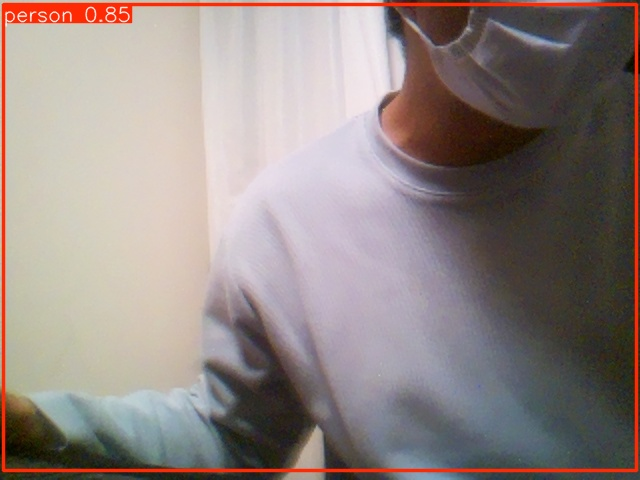

Detected box coordinates: x1=3.3, y1=5.0, x2=636.8, y2=470.7
Object is centered.



KeyboardInterrupt: 

In [11]:
while True:
    image = yolo_camera_manager.capture_image()

    results = yolo_camera_manager.get_results_from_image(image=image, classes=[0], conf=0.5)

    if len(results[0].boxes) == 0:
        clear_output(wait=True)
        display(Image(data=cv2.imencode(".jpg", image)[1].tobytes()))
        print("No object detected.")
        continue

    annotated_image = yolo_camera_manager.get_annotated_image(results)

    x1, y1, x2, y2 = results[0].boxes[0].xyxy[0].cpu().numpy()

    clear_output(wait=True)
    display(Image(data=cv2.imencode(".jpg", annotated_image)[1].tobytes()))
    print(f"Detected box coordinates: x1={x1:.1f}, y1={y1:.1f}, x2={x2:.1f}, y2={y2:.1f}")

    diff_x = (x1 + x2) / 2 - x_size / 2
    diff_y = (y1 + y2) / 2 - y_size / 2

    if abs(diff_x) < 20 and abs(diff_y) < 20:
        print("Object is centered.")
    else:
        angle_x = -diff_x / x_size * 60
        angle_y = diff_y / y_size * 60

        dual_servo_controller.move_by_angles(angle_x, angle_y)

        print(f"Moving servos by angles: angle_x={angle_x:.2f}, angle_y={angle_y:.2f}")